#  AGN fraction vs Ne Spectral Lines Ratios

Import of the libraries

In [1]:
from astropy.table import Table, Column, table, vstack, join
from pathlib import Path

import numpy as np
import astropy.units as u

from matplotlib import pyplot as plt

Reading the different paths where the results has been saved

In [2]:
path_raw='../Datos/Raw/'
path_phot_ned = '../Datos/Work/Phot_Tables_NED/' #In this path wi will save the photometry tables for each object
path_phot_cds = '../Datos/Work/Phot_Tables_CDS/'
path_SED = '../Datos/Work/SEDs/'
path_CIGALE_phot = '../Datos/Work/CIGALE_InputPhot/'
path_CIGALE_out = '../Datos/Work/CIGALE_Output/'
path_FINAL = '../Datos/Final/'

In [3]:
date_sample = 'Sep_02_2022'
NeV_NeII_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')
NeV_NeIII_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')
NeIII_NeII_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')

We remove the galaxies without energy balance that was removed in the CIGALE's phot files (Notebook 04).

In [4]:
CIG_BadGalaxies = Table.read('../Datos/Complementary/CIGPhot_BadEnergyBalance.tbl', format='ascii')
for id in CIG_BadGalaxies['id']:
    NeV_NeII_Sy.remove_rows(np.where(NeV_NeII_Sy['Main_Id'] == id)[0])
    NeV_NeIII_Sy.remove_rows(np.where(NeV_NeIII_Sy['Main_Id'] == id)[0])
    NeIII_NeII_Sy.remove_rows(np.where(NeIII_NeII_Sy['Main_Id'] == id)[0])

Now we classify the tables according to their Ne line information

In [5]:
#Rows to be deleted or removed in each table
to_rem1 = [] 
to_rem2 = []
to_rem3 = []

for i in range(len(NeV_NeII_Sy)): 
    if (NeV_NeII_Sy['NED_Ne_IR_info'][i] != 'NeII|NeIII|NeV' and NeV_NeII_Sy['NED_Ne_IR_info'][i]!= 'NeII|NeV'):
        to_rem1.append(i)
        
for i in range(len(NeV_NeIII_Sy)): 
    if (NeV_NeIII_Sy['NED_Ne_IR_info'][i] != 'NeII|NeIII|NeV' and NeV_NeIII_Sy['NED_Ne_IR_info'][i]!= 'NeIII|NeV'):
        to_rem2.append(i)

for i in range(len(NeIII_NeII_Sy)): 
    if (NeV_NeII_Sy['NED_Ne_IR_info'][i] != 'NeII|NeIII|NeV' and NeV_NeII_Sy['NED_Ne_IR_info'][i]!= 'NeII|NeIII'):
        to_rem3.append(i)
    
NeV_NeII_Sy.remove_rows(to_rem1)
NeV_NeIII_Sy.remove_rows(to_rem2)
NeIII_NeII_Sy.remove_rows(to_rem3)
#NeII_NeV_Sy.show_in_notebook()
print('Total objects with [NeV] and [NeII] info:',len(NeV_NeII_Sy))
print('Total objects with [NeV] and [NeIII] info:',len(NeV_NeIII_Sy))
print('Total objects with [NeIII] and [NeII] info:',len(NeIII_NeII_Sy))

Total objects with [NeV] and [NeII] info: 180
Total objects with [NeV] and [NeIII] info: 178
Total objects with [NeIII] and [NeII] info: 221


## Extracting the Neon lines flux values from NED phot tables

In [6]:
def Neon_info(NED_table, Freq):
    
    '''
    This function create a new table from the Phot NED table
    but with the flux of [NeII] and [NeV]
    '''
    
    NED_table.remove_rows(np.where(NED_table['Flux_Density'].mask)[0])
    NED_table.remove_rows(np.where(NED_table['NED_Units'] == 'Jy')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] line (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] 14.4 (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] (IRS)')[0])
    NED_table.remove_rows(np.where(NED_table['Observed_Passband'] == '[Cl II] 14.37 (IRS)')[0])
    
    Ne_idx = [np.where(NED_table['Frequency'] == freq)[0] for freq in Freq]
    #print(Ne_idx)
    #print(len(Ne_idx))
    i = []
    Ne_table = Table()
    for idx in range(len(Freq)):
        Ne_table = vstack([Ne_table,NED_table[Ne_idx[idx]]])
    
    for ind in range(len(Ne_table)):
        i.append(ind)
    
    Ne_table['idx'] = i
    Ne_inf = Ne_table['idx','Observed_Passband','Flux_Density','NED_Uncertainty','NED_Units','Refcode']
    obs_passb = np.unique(Ne_inf['Observed_Passband'])
    #print(obs_passb)
    return Ne_inf

## Calculating the ratios: [NeV]/[NeII], [NeV]/[NeIII] and [NeIII]/[NeII]

In [7]:
def Ne_ratios(Ne_info,Nel1,Nel2,Nel1a,Nel2a,not_same_bib):
    
    '''
    This function is for compute the ratio between two Neon
    emission lines (line1/line2) that have the same bibcode
    '''
    #Extract the number value of the NED_Uncertainty
    for u in range(len(Ne_info)):
        #print(u,Ne_info['NED_Uncertainty'][u])
        if Ne_info['NED_Uncertainty'][u] != '':
            Ne_info['NED_Uncertainty'][u] = float(Ne_info['NED_Uncertainty'][u].split('+/-')[-1])
    
    bibcod, count = np.unique(Ne_info['Refcode'], return_counts=True)
    print('No. of [Ne] data',len(Ne_info))
    flag = 0 #Flag to detect when there is not info of the two Ne lines for the same bibcode
    
    #Print the lines passband names
    #print('Neon line 1:',Nel1,'& Neon line 2:',Nel2)
    #print('Others filter names for Neon line1:',Nel1a,'& Neon line 2:',Nel2a)
    
    Ne_ratio = []
    Ne_ratio_err = []
    Ne_filter = []
    refcode = []
    #print(Ne_info) #Print the Ne Info of each galaxy
    
    for idx,bib in enumerate(bibcod):
        i = np.where(Ne_info['Refcode'] == bib)[0]
        #The ratio [Ne]line1/[Ne]line2 is calculated for only the bibcodes that have both flux data
        if len(i)>=2:
            flag += 1
            #print(len(i))
            Neline1_i = 'nan'
            Neline2_i = 'nan'
            for j,ind in enumerate(i):
                if Nel1 in Ne_info['Observed_Passband'][ind] or Nel1a in Ne_info['Observed_Passband'][ind]:
                    #print('yes:',Nel1)
                    Neline1_i = ind
                elif Nel2 in Ne_info['Observed_Passband'][ind] or Nel2a in Ne_info['Observed_Passband'][ind]:
                    #print('yes:',Nel2)
                    Neline2_i = ind
            if Neline1_i != 'nan' and Neline2_i != 'nan':
                Neline1 = Ne_info['Flux_Density'][Neline1_i]
                Neline1_err = Ne_info['NED_Uncertainty'][Neline1_i]
                Neline2 = Ne_info['Flux_Density'][Neline2_i]
                Neline2_err = Ne_info['NED_Uncertainty'][Neline2_i]
                Neline1_Neline2 = Neline1/Neline2
                Ne_ratio.append(Neline1_Neline2)
                Ne_filter.append(Ne_info['Observed_Passband'][Neline1_i])
                Ne_filter.append(Ne_info['Observed_Passband'][Neline2_i])
                refcode.append(bib)
                #print('For bibcode',',',bib,Nel1,'index is:',Neline1_i,'and',Nel2,'index is:',Neline2_i)
                #print('For bibcode', bib,Nel1,'/',Nel2,'ratio is:',Neline1_Neline2)
                if Neline1_err != '' or Neline2_err != '':
                    Neline1_Neline2_err = Neline1_err/Neline2_err
                else:
                    Neline1_Neline2_err = np.nan #Se usa np.nan para poder hacer operaciones mat con este
                Ne_ratio_err.append(Neline1_Neline2_err)
            #In some cases there is two data for one bibcode but for the same spectral line
            elif (Neline1_i == 'nan' and Neline2_i != 'nan') and len(Ne_info)==2:
                flag = 0
    if flag<1:
        not_same_bib += 1
        #for r in range(len(NeV_NeII_inf)): refcode.append(NeV_NeII_inf['Refcode'][r])
         
    return Ne_ratio, Ne_ratio_err, Ne_filter, refcode, not_same_bib

In the galaxies where there are more than one data of [NeII] or [NeV], we remove the rows if per bibcode there is data for only one the them. The idea is to have both [NeII] and [NeV] data per bibcode:

## [NeV]/[NeII]

In [8]:
Nefilter = []
Refcode = []
NeV_NeII = Table(names=('Main_id','otype','redshift','[NeV]/[NeII]','[NeV]/[NeII]_err'),
                dtype=('O','O','f8','f8','f8'))

not_same_bib = 0

for id in range(len(NeV_NeII_Sy)):
    NED_phot = Table()
    obj = NeV_NeII_Sy['Main_Id'][id]    
    otype = NeV_NeII_Sy['otype_txt'][id]
    z = NeV_NeII_Sy['redshift'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    NeV_NeII_Freq = [20900000000000.0,21000000000000.0,23400000000000.0]
    NeV_NeII_inf = Neon_info(NED_phot, NeV_NeII_Freq)
    
    NeV_NeII_ratios,NeV_NeII_ratios_err,Ne_filter,refcode,not_same_bib = \
    Ne_ratios(NeV_NeII_inf,'[Ne V]','[Ne II]','nan','nan',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
        
    avg_Ne_ratios = np.average(NeV_NeII_ratios)
    std_Ne_ratios = np.std(NeV_NeII_ratios)
    std = np.sqrt(np.sum(np.array(NeV_NeII_ratios_err)**2))
    NeV_NeII_row = [obj,otype,z,avg_Ne_ratios,std_Ne_ratios]
    NeV_NeII.add_row(vals=NeV_NeII_row)

    print(NeV_NeII_ratios)
    print(NeV_NeII_ratios_err)
    print(refcode)
    print('\n')
    
print('Number of galaxies with diferent bibcode for [NeV] and [NeII] fluxes:',not_same_bib)
print('Galaxies idx with diferent bibcode for [NeV] and [NeII] fluxes:',\
      np.where(np.isnan(NeV_NeII['[NeV]/[NeII]']))[0])

#Uncomment the 'for' lines for print the 'Observed_passband'and the Ŕefcodes' with [NeV] and [NeII] information
Ne_filters1, countspb1 = np.unique(Nefilter, return_counts=True)
#for pb in range(len(Ne_filters1)): print(Ne_filters1[pb])
    
refcodes1, countsrc1 = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes1)): print(refcodes1[rc])

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
[4.125]
[3.5]
['2006ApJ...647..161O']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 7
[0.3548780487804878, 0.45098039215686275, 0.3548780487804878]
[1.0, 0.4864864864864865, nan]
['2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


2
Galaxy:  IRAS 04385-0828
Phot table lenght: 97
No. of [Ne] data 5
[0.16402877697841728, 0.16402877697841728]
[0.8867924528301887, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


3
Galaxy:  Mrk  279
Phot table lenght: 188
No. of [Ne] data 5
[0.4275184275184275]
[0.7604166666666666]
['2011ApJ...740...94D']


4
Galaxy:  LEDA   45656
Phot table lenght: 128
No. of [Ne] data 3
[1.414572864321608]
[nan]
['2006ApJ...649...79S']


5
Galaxy:  Mrk 1239
Phot table lenght: 145
No. of [Ne] data 5
[0.3617021276595745, 0.3617021276595745]
[0.5434782608695652, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


6
Galaxy:  NGC  3735
Phot table lenght: 93
No. of [Ne] dat

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 2
[1.7333333333333334]
[nan]
['2010ApJ...725.2270P']


18
Galaxy:  NGC  3281
Phot table lenght: 150
No. of [Ne] data 4
[2.386934673366834, 2.764705882352941]
[1.2731481481481481, nan]
['2010ApJ...716.1151W', '2010ApJ...725.2270P']


19
Galaxy:  LEDA  101275
Phot table lenght: 116
No. of [Ne] data 3
[0.5664335664335665]
[nan]
['2011ApJS..193...18W']


20
Galaxy:  NAME Circinus Galaxy
Phot table lenght: 258
No. of [Ne] data 9
[0.5128805620608899, 0.4801762114537445, 0.3522222222222222]
[nan, 0.696551724137931, nan]
['2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


21
Galaxy:  IC 3639
Phot table lenght: 188
No. of [Ne] data 6
[0.23076923076923078, 0.21428571428571427, 0.24778761061946902]
[1.5, nan, nan]
['2007ApJ...671..124D', '2010ApJ...725.2270P', '2011ApJS..195...17W']


22
Galaxy:  Mrk  926
Phot table lenght: 205
No. of [Ne] data 5
[0.5293005671077504, 0.3788487282463186]
[0.8717948717948718, 1.413978494623656]
['2010ApJ...716.1151W', '2011ApJ..

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 13
[0.8, 0.5753731343283582, 0.5877862595419847, 0.4745762711864407, 0.4661016949152542]
[2.0, nan, nan, 0.9166666666666666, nan]
['2007ApJ...671..124D', '2009ApJ...690.1105K', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


36
Galaxy:  ESO 434-40
Phot table lenght: 211
No. of [Ne] data 2
[0.6132596685082873]
[1.1904761904761905]
['2010ApJ...716.1151W']


37
Galaxy:  ESO 323-77
Phot table lenght: 110
No. of [Ne] data 2
[0.13532338308457711]
[1.1418439716312057]
['2010ApJ...716.1151W']


38
Galaxy:  FRL   49
Phot table lenght: 130
No. of [Ne] data 4
[0.6439393939393939, 0.7146739130434783]
[1.0102389078498293, 1.2307692307692308]
['2010ApJ...716.1151W', '2011ApJ...740...94D']


39
Galaxy:  LEDA   50824
Phot table lenght: 114
No. of [Ne] data 6
[2.6481994459833795, 1.4295154185022025]
[nan, 0.7341772151898734]
['2006ApJ...649...79S', '2011ApJ...740...94D']


40
Galaxy:  Mrk  471
Phot table lenght: 139
No. of [Ne] data 3
[0.6666666666666666]
[1.0]
[

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 11
[1.3841961852861036, 1.0060240963855422, 1.4404761904761905, 1.0060240963855422]
[nan, 1.0576923076923077, 6.333333333333333, nan]
['2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


45
Galaxy:  NGC   973
Phot table lenght: 105
No. of [Ne] data 2
[0.2577833125778331]
[2.0]
['2010ApJ...716.1151W']


46
Galaxy:  2E  3648
Phot table lenght: 181
No. of [Ne] data 3
[1.7878787878787878]
[4.25]
['2007ApJ...660..117C']


47
Galaxy:  2MASX J22041914+0333511
Phot table lenght: 67
No. of [Ne] data 2
[1.4]
[nan]
['2011ApJS..195...17W']


48
Galaxy:  NGC  7469
Phot table lenght: 575
No. of [Ne] data 14
[0.07246376811594203, 0.06, 0.08020833333333334, 0.04670391061452514]
[nan, nan, 0.37037037037037035, nan]
['2009ApJ...690.1105K', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..193...18W']


49
Galaxy:  IRAS F08216+3009
Phot table lenght: 110
No. of [Ne] data 2
[1.0873493975903614]
[1.3627450980392157]
['2011ApJ...740...94D']



No. of [Ne] data 4
[1.234251968503937]
[nan]
['2009ApJ...690.1105K']


95
Galaxy:  NGC  5347
Phot table lenght: 154
No. of [Ne] data 7
[0.3872832369942196, 0.4988009592326139, 0.4988009592326139]
[nan, 0.8414634146341463, nan]
['2009ApJ...690.1105K', '2010ApJ...709.1257T', '2011ApJS..195...17W']


96
Galaxy:  NGC  4748
Phot table lenght: 158
No. of [Ne] data 6
[1.0714285714285714, 0.9158751696065129]
[1.0, nan]
['2007ApJ...671..124D', '2011ApJS..195...17W']


97
Galaxy:  NGC  1667
Phot table lenght: 169
No. of [Ne] data 6
[0.1306930693069307, 0.1306930693069307]
[0.8666666666666667, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


98
Galaxy:  NGC  1320
Phot table lenght: 128
No. of [Ne] data 6
[0.8888888888888888, 1.116910229645094, 0.8888888888888888]
[1.0, 0.9722222222222222, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2011ApJS..195...17W']


99
Galaxy:  Mrk 1073
Phot table lenght: 133
No. of [Ne] data 3
[0.5520282186948854]
[0.5425531914893617]
['2011ApJ...740...94D']


/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 5
[0.05042918454935622]
[0.013888888888888888]
['2010ApJ...716.1151W']


136
Galaxy:  UGC 12138
Phot table lenght: 120
No. of [Ne] data 2
[2.0]
[1.0]
['2007ApJ...671..124D']


137
Galaxy:  IC 2560
Phot table lenght: 122
No. of [Ne] data 2
[1.1875]
[nan]
['2010ApJ...725.2270P']


138
Galaxy:  NGC  5995
Phot table lenght: 153
No. of [Ne] data 8
[0.8571428571428571, 0.3715151515151515, 0.5714285714285714, 0.3715151515151515]
[1.0, 0.631578947368421, 0.743455497382199, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


139
Galaxy:  2MASSI J0918486+211717
Phot table lenght: 73
No. of [Ne] data 2
[4.562118126272912]
[nan]
['2009ApJ...690.1105K']


140
Galaxy:  LEDA   17155
Phot table lenght: 266
No. of [Ne] data 7
[0.8518518518518519, 0.796875, 1.1875]
[1.3517786561264822, 1.348314606741573, nan]
['2007ApJ...656..148A', '2011ApJ...740...94D', '2011ApJS..195...17W']


141
Galaxy:  2MASX J08584172+1041223
Phot table lenght: 81
N

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 2
[0.5774378585086042]
[0.8736842105263158]
['2011ApJ...740...94D']


148
Galaxy:  UGC  3601
Phot table lenght: 69
No. of [Ne] data 2
[0.3821292775665399]
[0.22641509433962265]
['2010ApJ...716.1151W']


149
Galaxy:  ESO  33-2
Phot table lenght: 126
No. of [Ne] data 3
[2.0861423220973783]
[3.111111111111111]
['2010ApJ...716.1151W']


150
Galaxy:  NGC  7682
Phot table lenght: 129
No. of [Ne] data 3
[0.3626373626373626]
[0.76]
['2010ApJ...716.1151W']


151
Galaxy:  7C 1821+6419
Phot table lenght: 120
No. of [Ne] data 2
[1.8472727272727272]
[0.8203883495145631]
['2011ApJ...740...94D']


152
Galaxy:  MCG-01-24-012
Phot table lenght: 96
No. of [Ne] data 2
[0.43026706231454004]
[0.6585365853658537]
['2010ApJ...716.1151W']


153
Galaxy:  NGC  1358
Phot table lenght: 71
No. of [Ne] data 2
[0.6862745098039216]
[nan]
['2010ApJ...725.2270P']


154
Galaxy:  NGC  2110
Phot table lenght: 230
No. of [Ne] data 4
[0.09156414762741652, 0.0867109634551495]
[nan, 0.15355805243445692]
['200

In [9]:
NeV_NeII.remove_rows(np.where(np.isnan(NeV_NeII['[NeV]/[NeII]']))[0])

## [NeV]/[NeIII]

In [10]:
Nefilter = []
Refcode = []
NeV_NeIII = Table(names=('Main_id','otype','redshift','[NeV]/[NeIII]','[NeV]/[NeIII]_err'),
                 dtype=('O','O','f8','f8','f8'))

not_same_bib = 0

for id in range(len(NeV_NeIII_Sy)):
    NED_phot = Table()
    obj = NeV_NeIII_Sy['Main_Id'][id]
    otype = NeV_NeIII_Sy['otype_txt'][id]
    z = NeV_NeIII_Sy['redshift'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    #Put first the frequencies of the Ne line 1 and then the Ne line 2
    NeV_NeIII_Freq = [20900000000000.0,21000000000000.0,19200000000000.0,19300000000000.0]
    NeV_NeIII_inf = Neon_info(NED_phot, NeV_NeIII_Freq)
    
    NeV_NeIII_ratios,NeV_NeIII_ratios_err,Ne_filter,refcode,not_same_bib = \
    Ne_ratios(NeV_NeIII_inf,'[Ne V]','[Ne III]','nan','[NeIII]',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
        
    avg_Ne_ratios = np.average(NeV_NeIII_ratios)
    std_Ne_ratios = np.std(NeV_NeIII_ratios)
    std = np.sqrt(np.sum(np.array(NeV_NeIII_ratios_err)**2))
    NeV_NeIII_row = [obj,otype,z,avg_Ne_ratios,std_Ne_ratios]
    NeV_NeIII.add_row(vals=NeV_NeIII_row)
    
    print(NeV_NeIII_ratios)
    print(NeV_NeIII_ratios_err)
    print(refcode)
    print('\n')

print('Number of galaxies with diferent bibcode for [NeV] and [NeIII] fluxes:',not_same_bib)
print('Galaxies idx with diferent bibcode for [NeV] and [NeIII] fluxes:',\
      np.where(np.isnan(NeV_NeIII['[NeV]/[NeIII]']))[0])

#Uncomment the 'for' lines for print the 'Observed_passband'and the Ŕefcodes' with [NeV] and [NeIII] information
Ne_filters2, countspb2 = np.unique(Nefilter, return_counts=True)
#for pb in range(len(Ne_filters2)): print(Ne_filters2[pb])
    
refcodes2, countsrc2 = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes2)): print(refcodes2[rc])

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
[0.4024390243902439, 0.6911764705882353]
[1.0, 0.7352941176470589]
['2006ApJ...647..161O', '2010ApJ...709.1257T']


1
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 7
[0.2852941176470588, 0.33495145631067963, 0.2852941176470588]
[0.9210526315789473, 0.45569620253164556, nan]
['2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


2
Galaxy:  IRAS 04385-0828
Phot table lenght: 97
No. of [Ne] data 5
[0.32294617563739375, 0.32294617563739375]
[1.146341463414634, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


3
Galaxy:  Mrk  279
Phot table lenght: 188
No. of [Ne] data 5
[0.43283582089552236]
[0.5516372795969773]
['2011ApJ...740...94D']


4
Galaxy:  Mrk 1239
Phot table lenght: 145
No. of [Ne] data 4
[0.3624733475479744, 0.3624733475479744]
[0.7575757575757576, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


5
Galaxy:  NAME 3C 330G2
Phot table lenght: 90
No. of [Ne] data 6
[0.571428571428571

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Phot table lenght: 142
No. of [Ne] data 3
[0.3072139303482587]
[0.7098976109215017]
['2011ApJ...740...94D']


17
Galaxy:  NGC   863
Phot table lenght: 198
No. of [Ne] data 4
[0.45355450236966827]
[0.6456692913385826]
['2011ApJ...740...94D']


18
Galaxy:  IRAS 11215-2806
Phot table lenght: 19
No. of [Ne] data 2
[0.5]
[nan]
['2010ApJ...725.2270P']


19
Galaxy:  NGC  3281
Phot table lenght: 150
No. of [Ne] data 4
[0.8133561643835616, 0.8103448275862069]
[1.1088709677419355, nan]
['2010ApJ...716.1151W', '2010ApJ...725.2270P']


20
Galaxy:  LEDA  101275
Phot table lenght: 116
No. of [Ne] data 2
[0.23142857142857143]
[nan]
['2011ApJS..193...18W']


21
Galaxy:  NAME Circinus Galaxy
Phot table lenght: 258
No. of [Ne] data 7
[0.5778364116094987, 0.545, 0.9462686567164179]
[nan, 1.1222222222222222, nan]
['2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


22
Galaxy:  IC 3639
Phot table lenght: 188
No. of [Ne] data 6
[0.2647058823529412, 0.3333333333333333, 0.4148148148148148]


/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 11
[0.8488372093023255, 0.7514792899408284, 0.8520408163265306, 0.9138972809667674, 0.8520408163265306]
[nan, nan, 1.0784313725490196, 2.303030303030303, nan]
['2007ApJ...655L..73G', '2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


46
Galaxy:  NGC   973
Phot table lenght: 105
No. of [Ne] data 2
[0.2320627802690583]
[0.47368421052631576]
['2010ApJ...716.1151W']


47
Galaxy:  2E  3648
Phot table lenght: 181
No. of [Ne] data 4
[0.75, 0.7283950617283951]
[nan, 1.3076923076923077]
['2007ApJ...655L..73G', '2007ApJ...660..117C']


48
Galaxy:  2MASX J22041914+0333511
Phot table lenght: 67
No. of [Ne] data 2
[0.5907801418439717]
[nan]
['2011ApJS..195...17W']


49
Galaxy:  NGC  7469
Phot table lenght: 575
No. of [Ne] data 13
[0.43103448275862066, 0.3333333333333333, 0.4301675977653631, 0.24807121661721068]
[nan, nan, 1.3333333333333333, nan]
['2009ApJ...690.1105K', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..193...18W']


50
Galaxy:  IRA

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 2
[0.48600883652430044]
[0.9523809523809523]
['2010ApJ...716.1151W']


72
Galaxy:  Mrk  618
Phot table lenght: 127
No. of [Ne] data 4
[0.7230483271375465, 0.7230483271375465]
[0.7454545454545455, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


73
Galaxy:  Mrk  609
Phot table lenght: 147
No. of [Ne] data 5
[1.0, 0.6825396825396826]
[0.5, 1.691699604743083]
['2007ApJ...671..124D', '2011ApJ...740...94D']


74
Galaxy:  NGC  3079
Phot table lenght: 331
No. of [Ne] data 9
[0.043859649122807015, 0.03791666666666667, 0.05646551724137931]
[nan, nan, nan]
['2007ApJ...655L..73G', '2010ApJ...725.2270P', '2011ApJS..195...17W']


75
Galaxy:  2C   94
Phot table lenght: 226
No. of [Ne] data 2
[0.37735849056603776]
[1.5]
['2006ApJ...647..161O']


76
Galaxy:  NGC  5548
Phot table lenght: 420
No. of [Ne] data 15
[0.5697674418604651, 0.35714285714285715, 0.41759352881698686, 0.7427785419532325, 0.21690767519466073, 0.38508557457212717, 0.7427785419532325]
[nan, 2.0, nan, 0.5, 0.1030

No. of [Ne] data 6
[2.0, 0.5226860254083484, 0.40611353711790393]
[1.0, 0.6233766233766234, nan]
['2007ApJ...671..124D', '2010ApJ...716.1151W', '2011ApJS..195...17W']


114
Galaxy:  Mrk  273
Phot table lenght: 353
No. of [Ne] data 8
[0.30210772833723654, 0.33136094674556216, 0.36551724137931035]
[0.41228070175438597, 1.48, nan]
['2007ApJ...656..148A', '2011ApJ...740...94D', '2011ApJS..193...18W']


115
Galaxy:  ICRF J134733.3+121724
Phot table lenght: 282
No. of [Ne] data 4
[0.15010570824524314, 0.5618729096989966]
[nan, 1.0476190476190477]
['2011ApJS..193...18W', '2012ApJ...747...95G']


116
Galaxy:  ESO 362-18
Phot table lenght: 190
No. of [Ne] data 6
[0.43658210947930576, 0.4399441340782123]
[1.0526315789473684, 2.0555555555555554]
['2010ApJ...709.1257T', '2010ApJ...716.1151W']


117
Galaxy:  IC  450
Phot table lenght: 233
No. of [Ne] data 4
[0.2553191489361702, 0.19046653144016226]
[1.0, nan]
['2007ApJ...671..124D', '2011ApJS..195...17W']


118
Galaxy:  MCG-02-08-039
Phot table len

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 2
[0.78515625]
[1.2809523809523808]
['2011ApJ...740...94D']


147
Galaxy:  Mrk  705
Phot table lenght: 181
No. of [Ne] data 2
[0.6088709677419355]
[0.7867298578199052]
['2011ApJ...740...94D']


148
Galaxy:  UGC  3601
Phot table lenght: 69
No. of [Ne] data 2
[0.2644736842105263]
[0.9230769230769231]
['2010ApJ...716.1151W']


149
Galaxy:  3C 286
Phot table lenght: 252
No. of [Ne] data 4
[1.1428571428571428, 1.0869565217391304]
[nan, 0.6666666666666666]
['2007ApJ...655L..73G', '2007ApJ...660..117C']


150
Galaxy:  ESO  33-2
Phot table lenght: 126
No. of [Ne] data 4
[0.6666666666666666, 0.6678657074340527]
[1.0, 1.0]
['2007ApJ...671..124D', '2010ApJ...716.1151W']


151
Galaxy:  NGC  7682
Phot table lenght: 129
No. of [Ne] data 3
[0.24535315985130113]
[1.2666666666666666]
['2010ApJ...716.1151W']


152
Galaxy:  7C 1821+6419
Phot table lenght: 120
No. of [Ne] data 2
[0.48846153846153845]
[0.4828571428571429]
['2011ApJ...740...94D']


153
Galaxy:  MCG-01-24-012
Phot table leng

In [11]:
NeV_NeIII.remove_rows(np.where(np.isnan(NeV_NeIII['[NeV]/[NeIII]']))[0])

## [NeIII]/[NeII]

In [12]:
Nefilter = []
Refcode = []
NeIII_NeII = Table(names=('Main_id','otype','redshift','[NeIII]/[NeII]','[NeIII]/[NeII]_err'),
                   dtype=('O','O','f8','f8','f8'))

not_same_bib = 0

for id in range(len(NeIII_NeII_Sy)):
    NED_phot = Table()
    obj = NeIII_NeII_Sy['Main_Id'][id]
    otype = NeIII_NeII_Sy['otype_txt'][id]
    z = NeIII_NeII_Sy['redshift'][id]
    print(id)
    print('Galaxy: ',obj)

    NED_phot = Table.read(path_phot_ned+obj+'_NED_phot_tables'+'.vot', format='votable')
    print('Phot table lenght:',len(NED_phot))
    
    #Put first the frequencies of the Ne line 1 and then the Ne line 2
    NeIII_NeII_Freq = [19200000000000.0,19300000000000.0,23400000000000.0]
    NeIII_NeII_inf = Neon_info(NED_phot, NeIII_NeII_Freq)
    
    NeIII_NeII_ratios,NeIII_NeII_ratios_err,Ne_filter,refcode,not_same_bib = \
    Ne_ratios(NeIII_NeII_inf,'[Ne III]','[Ne II]','[NeIII]','nan',not_same_bib)
    
    for r in range(len(refcode)): Refcode.append(refcode[r])
    for f in range(len(Ne_filter)): Nefilter.append(Ne_filter[f])
    
    avg_Ne_ratios = np.average(NeIII_NeII_ratios)
    std_Ne_ratios = np.std(NeIII_NeII_ratios)
    std = np.sqrt(np.sum(np.array(NeIII_NeII_ratios_err)**2))
    NeIII_NeII_row = [obj,otype,z,avg_Ne_ratios,std_Ne_ratios]
    NeIII_NeII.add_row(vals=NeIII_NeII_row)

    print(NeIII_NeII_ratios)
    print(NeIII_NeII_ratios_err)
    print(refcode)
    print('\n')

print('Number of galaxies with diferent bibcode for [NeIII] and [NeII] fluxes:',not_same_bib)
print('Galaxies idx with diferent bibcode for [NeIII] and [NeII] fluxes:',\
      np.where(np.isnan(NeIII_NeII['[NeIII]/[NeII]']))[0])

#Uncomment the 'for' lines for print the 'Observed_passband'and the Ŕefcodes' with [NeIII] and [NeII] information
Ne_filters3, countspb3 = np.unique(Nefilter, return_counts=True)
#for pb in range(len(Ne_filters3)): print(Ne_filters3[pb])

refcodes3, countsrc3 = np.unique(Refcode, return_counts=True)
#for rc in range(len(refcodes3)): print(refcodes3[rc])

0
Galaxy:  3C 234.0
Phot table lenght: 253
No. of [Ne] data 4
[10.25]
[3.5]
['2006ApJ...647..161O']


1
Galaxy:  2MASS J13000535+1632148
Phot table lenght: 98
No. of [Ne] data 2
[0.8682634730538922]
[nan]
['2009ApJ...690.1105K']


2
Galaxy:  NGC   262
Phot table lenght: 334
No. of [Ne] data 8
[1.9230769230769231, 1.2439024390243902, 1.34640522875817, 1.2439024390243902]
[1.0, 1.0857142857142856, 1.0675675675675675, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


3
Galaxy:  IRAS 04385-0828
Phot table lenght: 97
No. of [Ne] data 6
[0.75, 0.5079136690647482, 0.5079136690647482]
[1.0, 0.7735849056603774, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2011ApJS..195...17W']


4
Galaxy:  IC 4553
Phot table lenght: 404
No. of [Ne] data 4
[0.12817109144542774, 0.1127659574468085]
[0.1043956043956044, nan]
['2007ApJ...656..148A', '2011ApJS..193...18W']


5
Galaxy:  Mrk  279
Phot table lenght: 188
No. of [Ne] data 4
[1.5365853658536586, 0.

No. of [Ne] data 2
[0.38809831824062097]
[0.38939197930142305]
['2012ApJ...744....2A']


52
Galaxy:  IRAS 11119+3257
Phot table lenght: 92
No. of [Ne] data 2
[0.863013698630137]
[nan]
['2011ApJS..193...18W']


53
Galaxy:  IC 1065
Phot table lenght: 211
No. of [Ne] data 2
[2.07710843373494]
[2.0344827586206895]
['2012ApJ...747...95G']


54
Galaxy:  M  81
Phot table lenght: 294
No. of [Ne] data 2
[0.7777777777777778]
[nan]
['2010ApJ...725.2270P']


55
Galaxy:  2MASS J14533151+1353587
Phot table lenght: 64
No. of [Ne] data 2
[0.9958071278825996]
[nan]
['2009ApJ...690.1105K']


56
Galaxy:  NGC  2639
Phot table lenght: 175
No. of [Ne] data 8
[0.5454545454545454, 0.4311557788944724, 0.550561797752809, 0.5672853828306265]
[0.5, 1.1818181818181819, nan, 0.7330827067669173]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...725.2270P', '2011ApJ...740...94D']


57
Galaxy:  NGC   513
Phot table lenght: 124
No. of [Ne] data 6
[0.7272727272727273, 0.4528846153846154, 0.34609375]
[1.0, 0.1797

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 2
[1.7]
[nan]
['2010ApJ...725.2270P']


92
Galaxy:  Mrk  609
Phot table lenght: 147
No. of [Ne] data 6
[0.75, 0.5, 0.2649532710280374]
[1.0, 1.3333333333333333, 0.4080645161290323]
['2007ApJ...671..124D', '2010ApJ...725..605S', '2011ApJ...740...94D']


93
Galaxy:  NGC  3079
Phot table lenght: 331
No. of [Ne] data 11
[0.1891891891891892, 0.23434343434343435, 0.2222222222222222, 0.18167938931297709, 0.23434343434343435]
[0.1111111111111111, 0.22660098522167488, nan, 0.055, nan]
['2007ApJ...671..124D', '2009ApJS..184..230B', '2010ApJ...725.2270P', '2011ApJ...740...94D', '2011ApJS..195...17W']


94
Galaxy:  IRAS 03450+0055
Phot table lenght: 109
No. of [Ne] data 4
[1.6697247706422018, 1.6697247706422018]
[1.0, nan]
['2010ApJ...709.1257T', '2011ApJS..195...17W']


95
Galaxy:  2C   94
Phot table lenght: 226
No. of [Ne] data 2
[1.358974358974359]
[1.0]
['2006ApJ...647..161O']


96
Galaxy:  NGC  5548
Phot table lenght: 420
No. of [Ne] data 14
[3.5, 1.0832420591456735, 0.858323

No. of [Ne] data 2
[0.17215189873417722]
[nan]
['2011ApJS..193...18W']


136
Galaxy:  ESO 445-50
Phot table lenght: 344
No. of [Ne] data 15
[2.6923076923076925, 1.9406392694063928, 2.0652173913043477, 2.162251655629139, 2.2107438016528924, 2.0652173913043477]
[3.0, nan, 1.3287671232876712, 0.3442028985507246, 1.096774193548387, nan]
['2007ApJ...671..124D', '2009ApJ...690.1105K', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJ...740...94D', '2011ApJS..195...17W']


137
Galaxy:  Mrk  817
Phot table lenght: 200
No. of [Ne] data 7
[0.8, 1.2056892778993435, 1.195822454308094]
[1.0, 0.875, nan]
['2007ApJ...671..124D', '2010ApJ...716.1151W', '2011ApJS..195...17W']


138
Galaxy:  NGC  6810
Phot table lenght: 147
No. of [Ne] data 2
[0.13009708737864079]
[0.25]
['2010ApJ...709.1257T']


139
Galaxy:  Mrk  273
Phot table lenght: 353
No. of [Ne] data 6
[0.7981308411214953, 0.7595505617977528, 0.7038834951456311]
[1.8, 0.31645569620253167, nan]
['2007ApJ...656..148A', '2011ApJ...740...94D', '

/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 2
[2.6666666666666665]
[1.0]
['2007ApJ...671..124D']


167
Galaxy:  IC 2560
Phot table lenght: 122
No. of [Ne] data 2
[2.25]
[nan]
['2010ApJ...725.2270P']


168
Galaxy:  NGC  1125
Phot table lenght: 77
No. of [Ne] data 2
[1.1481481481481481]
[0.125]
['2007ApJ...671..124D']


169
Galaxy:  LEDA   24384
Phot table lenght: 100


/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jonhatan/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No. of [Ne] data 2
[]
[]
[]


170
Galaxy:  M 106
Phot table lenght: 237
No. of [Ne] data 4
[0.675, 0.5693548387096774]
[nan, 0.7684931506849315]
['2010ApJ...725.2270P', '2011ApJ...740...94D']


171
Galaxy:  NGC  5995
Phot table lenght: 153
No. of [Ne] data 8
[1.2857142857142858, 0.5133333333333333, 0.6909774436090226, 0.5133333333333333]
[2.0, 0.6666666666666666, 0.3089005235602094, nan]
['2007ApJ...671..124D', '2010ApJ...709.1257T', '2010ApJ...716.1151W', '2011ApJS..195...17W']


172
Galaxy:  2MASSI J0918486+211717
Phot table lenght: 73
No. of [Ne] data 3
[2.6476578411405294]
[nan]
['2009ApJ...690.1105K']


173
Galaxy:  LEDA   17155
Phot table lenght: 266
No. of [Ne] data 6
[0.8611111111111112, 0.96875, 1.125]
[0.6126482213438735, 0.797752808988764, nan]
['2007ApJ...656..148A', '2011ApJ...740...94D', '2011ApJS..195...17W']


174
Galaxy:  2MASX J08584172+1041223
Phot table lenght: 81
No. of [Ne] data 2
[0.22315035799522673]
[nan]
['2011ApJS..193...18W']


175
Galaxy:  3C 343
Phot table

[0.827433628318584, 0.8813559322033898, 0.9039812646370023]
[nan, 0.25, 1.3125]
['2009ApJ...690.1105K', '2010ApJ...725..605S', '2011ApJ...740...94D']


217
Galaxy:  2MASS J10434845+5811477
Phot table lenght: 103
No. of [Ne] data 4
[0.1182825484764543]
[1.2222222222222223]
['2011ApJ...741...76C']


218
Galaxy:  NGC  3081
Phot table lenght: 171
No. of [Ne] data 6
[2.832, 2.8968253968253967, 2.8333333333333335]
[nan, 1.0775862068965518, nan]
['2009ApJ...690.1105K', '2010ApJ...716.1151W', '2010ApJ...725.2270P']


219
Galaxy:  NGC  4507
Phot table lenght: 252
No. of [Ne] data 9
[0.9582089552238806, 0.8486646884272997, 0.9666666666666667, 0.935064935064935]
[nan, 0.8973384030418251, nan, 0.9130434782608695]
['2009ApJ...690.1105K', '2010ApJ...716.1151W', '2010ApJ...725.2270P', '2011ApJ...740...94D']


220
Galaxy:  2MASX J00215355-7910077
Phot table lenght: 63
No. of [Ne] data 2
[2.261712439418417]
[nan]
['2011ApJS..195...17W']


Number of galaxies with diferent bibcode for [NeIII] and [NeII] 

In [13]:
NeIII_NeII.remove_rows(np.where(np.isnan(NeIII_NeII['[NeIII]/[NeII]']))[0])

## Joining tables with CIGALE results:

In [14]:
CIGresults = Table.read(path_CIGALE_out+'results_All.fits', format='fits')
CIGresults = CIGresults['id','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.agn.i','bayes.agn.i_err','best.reduced_chi_square']
CIGresults['id'] = CIGresults['id'].astype(str) #Converting the dtype to string
CIGresults['id'] = CIGresults['id'].astype(object) #Converting the dtype to object
CIGresults['id'].name = 'Main_id' #Changing the column name
#CIGresults.show_in_notebook()

In [15]:
NeVNeII = join(NeV_NeII, CIGresults, join_type='left', keys='Main_id')
#NeVNeII.show_in_notebook()

In [16]:
NeVNeIII = join(NeV_NeIII, CIGresults, join_type='left', keys='Main_id')
#NeVNeIII.show_in_notebook()

In [17]:
NeIIINeII = join(NeIII_NeII, CIGresults, join_type='left', keys='Main_id')
#NeIIINeII.show_in_notebook()

In [18]:
NeVNeIINeIII = join(NeVNeII, NeVNeIII, join_type='outer')
Ne_Sy = join(NeVNeIINeIII, NeIIINeII, join_type='outer')
Ne_Sy = Ne_Sy.filled(np.nan) #Fill the mask values (---) with numpy.nan
Ne_Sy.show_in_notebook()

idx,Main_id,otype,redshift,[NeV]/[NeII],[NeV]/[NeII]_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,best.reduced_chi_square,[NeV]/[NeIII],[NeV]/[NeIII]_err,[NeIII]/[NeII],[NeIII]/[NeII]_err
,,,,,,,,deg,deg,,,,,
0,2C 94,Sy2,0.059615,0.5128205128205128,0.0,0.6271137033489322,0.07211508083045369,70.5481626365572,9.301696231885996,3.2149343501052314,0.37735849056603776,0.0,1.358974358974359,0.0
1,2C 1883,Sy2,0.22,nan,nan,0.10049235409817402,0.00493775070050137,24.145652952403985,14.104110664351335,1.9118542546292236,nan,nan,0.3215434083601286,0.0
2,2E 2389,Sy1,0.3115,1.1556064073226544,0.0,0.8184210019817609,0.02413496360285592,27.186168205481057,10.652860210024379,1.4502115241831317,nan,nan,nan,nan
3,2E 3648,Sy1,0.55517,1.7878787878787878,0.0,0.7437710848035028,0.09751934233157432,39.19947158716953,3.128758941848712,2.285716871590449,0.7391975308641976,0.010802469135802462,2.4545454545454546,0.0
4,2MASS J00070361+1554238,Sy1,0.11405,1.1746724890829694,0.0,0.7159038375208355,0.05284894140341326,15.399676980778787,12.788757582113233,1.227168470785353,0.5085066162570888,0.0,2.3100436681222707,0.0
5,2MASS J10434845+5811477,Sy1,0.07317,nan,nan,0.8999044730680125,0.002245014447722756,8.480373425852274,9.212272322240578,58.841736258057026,nan,nan,0.1182825484764543,0.0
6,2MASS J10514425+3539307,Sy1,0.15879,0.9147727272727273,0.0,0.739336498151863,0.06704712731207804,66.04742180385735,5.360677620273422,1.3140030090149162,0.5331125827814569,0.0,1.7159090909090908,0.0
7,2MASS J13000535+1632148,Sy1,0.07993,nan,nan,0.899273174709466,0.005985980504553072,60.00034211182109,0.058489411166235517,2.8333819812086842,nan,nan,0.8682634730538922,0.0
8,2MASS J14533151+1353587,Sy1,0.13901,nan,nan,0.3789370779338508,0.11119084937583053,62.66029118693765,5.618746122851261,1.799265805098418,nan,nan,0.9958071278825996,0.0


## Graphics of Ne Line Ratios Histograms and Ne Line Ratios vs fracAGN

### [NeV]/[NeII]

Text(0, 0.5, 'Number of galaxies')

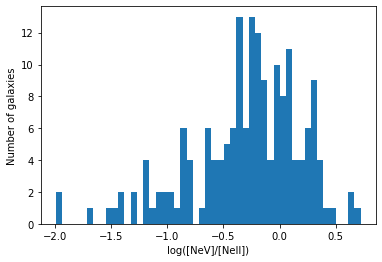

In [19]:
x_NeV_NeII_Sy = np.log10(Ne_Sy['[NeV]/[NeII]'])
#x_NeV_NeII_Sy = Ne_Sy['[NeV]/[NeII]']
bins_NeV_NeII_Sy = np.linspace(min(x_NeV_NeII_Sy),max(x_NeV_NeII_Sy),50)
plt.hist(x_NeV_NeII_Sy, bins=bins_NeV_NeII_Sy)
plt.xlabel('log([NeV]/[NeII])')
#plt.xscale('log')
plt.ylabel('Number of galaxies')

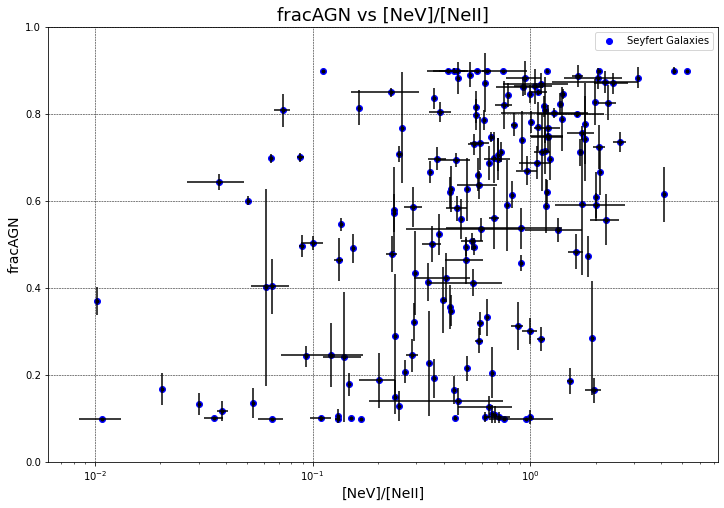

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(Ne_Sy['[NeV]/[NeII]'], Ne_Sy['bayes.agn.fracAGN'], color='blue', label='Seyfert Galaxies')
plt.errorbar(Ne_Sy['[NeV]/[NeII]'], Ne_Sy['bayes.agn.fracAGN'],\
             Ne_Sy['bayes.agn.fracAGN_err'], Ne_Sy['[NeV]/[NeII]_err'], fmt='k.')
plt.xlabel(r'[NeV]/[NeII]', fontsize=14)
plt.xscale('log')
plt.ylabel(r'fracAGN', fontsize=14)
plt.ylim(0.0,1.0)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.title(r'fracAGN vs [NeV]/[NeII]', fontsize=18)
plt.legend()
#plt.savefig('NeV_NeII_vs_fracAGN.jpg')
plt.show()

### [NeV]/[NeIII]

Text(0, 0.5, 'Number of galaxies')

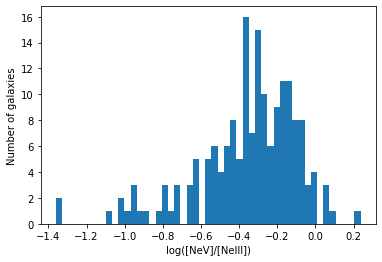

In [21]:
x_NeV_NeIII_Sy = np.log10(Ne_Sy['[NeV]/[NeIII]'])
#x_NeV_NeIII_Sy = Ne_Sy['[NeV]/[NeIII]']
bins_NeV_NeIII_Sy = np.linspace(min(x_NeV_NeIII_Sy),max(x_NeV_NeIII_Sy),50)
plt.hist(x_NeV_NeIII_Sy, bins=bins_NeV_NeIII_Sy)
plt.xlabel('log([NeV]/[NeIII])')
#plt.xscale('log')
plt.ylabel('Number of galaxies')

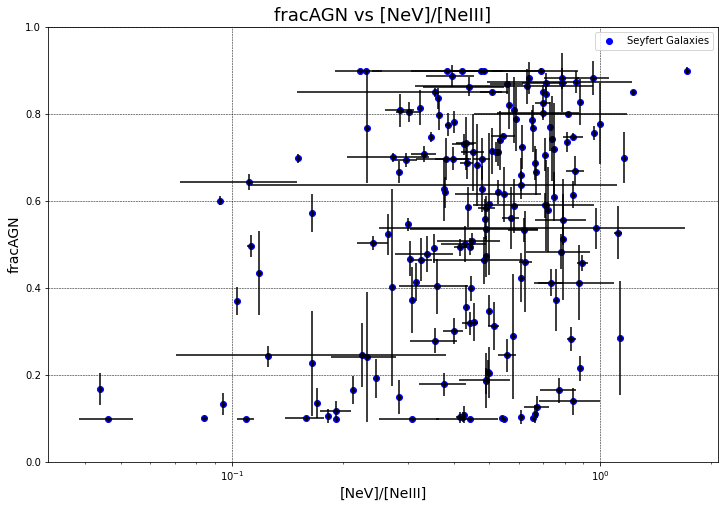

In [28]:
plt.figure(figsize=(12,8))
plt.scatter(Ne_Sy['[NeV]/[NeIII]'], Ne_Sy['bayes.agn.fracAGN'], color='blue', label='Seyfert Galaxies')
plt.errorbar(Ne_Sy['[NeV]/[NeIII]'], Ne_Sy['bayes.agn.fracAGN'],\
             Ne_Sy['bayes.agn.fracAGN_err'], Ne_Sy['[NeV]/[NeIII]_err'], fmt='k.')
plt.xlabel(r'[NeV]/[NeIII]', fontsize=14)
plt.xscale('log')
plt.ylabel(r'fracAGN', fontsize=14)
plt.ylim(0.0,1.0)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.title(r'fracAGN vs [NeV]/[NeIII]', fontsize=18)
plt.legend()
#plt.savefig('NeV_NeIII_vs_fracAGN.jpg')
plt.show()

### [NeIII]/[NeII]

Text(0, 0.5, 'Number of galaxies')

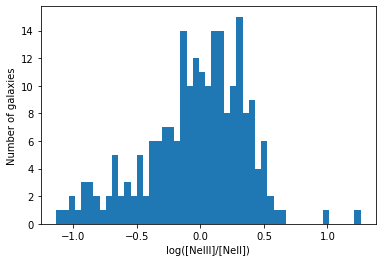

In [23]:
x_NeIII_NeII_Sy = np.log10(Ne_Sy['[NeIII]/[NeII]'])
#x_NeIII_NeII_Sy = Ne_Sy['[NeIII]/[NeII]']
bins_NeIII_NeII_Sy = np.linspace(min(x_NeIII_NeII_Sy),max(x_NeIII_NeII_Sy),50)
plt.hist(x_NeIII_NeII_Sy, bins=bins_NeIII_NeII_Sy)
plt.xlabel('log([NeIII]/[NeII])')
#plt.xscale('log')
plt.ylabel('Number of galaxies')

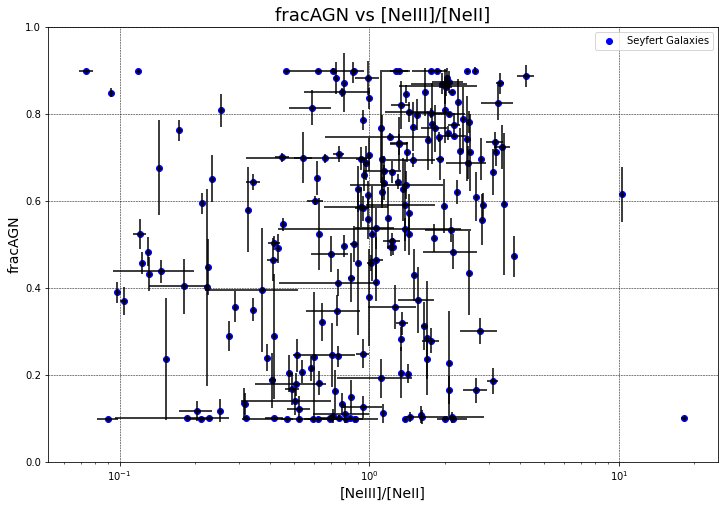

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(Ne_Sy['[NeIII]/[NeII]'], Ne_Sy['bayes.agn.fracAGN'], color='blue', label='Seyfert Galaxies')
plt.errorbar(Ne_Sy['[NeIII]/[NeII]'], Ne_Sy['bayes.agn.fracAGN'],\
             Ne_Sy['bayes.agn.fracAGN_err'], Ne_Sy['[NeIII]/[NeII]_err'], fmt='k.')
plt.xlabel(r'[NeIII]/[NeII]', fontsize=14)
plt.xscale('log')
plt.ylabel(r'fracAGN', fontsize=14)
plt.ylim(0.0,1.0)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.title(r'fracAGN vs [NeIII]/[NeII]', fontsize=18)
plt.legend()
#plt.savefig('NeIII_NeII_vs_fracAGN.jpg')
plt.show()

## Notebook Info

In [25]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.4.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-47-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.1

matplotlib: 3.5.1
numpy     : 1.21.5
astropy   : 5.1

Watermark: 2.3.1



### Las celdas a continuación son para pruebas:

Index removed for BadGalaxies from CIGALE phot files: 4, 99, 125, 145, 177, 220 and 292

In [26]:
Obj_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')
Obj_Sy['Main_Id','NED_Ne_IR_info'][292]

Main_Id,NED_Ne_IR_info
object,str14
IRAS F00183-7111,NeII|NeIII
